# Assignment 4

## Handin

1. A short abstract describing the project in your own words. This should be 200 words or less.

I decided to tackle the "Cancer Identification" task, which entails classifying tiles from large pathology slide scans. Really, the task should be to classify the _slide_, not the tiles, but that would require a little more coding than I think is really useful for this particular exercise. This is largely because of the way the training and testing data are split (more on this below). Anyway, I decided to train a classification network, taking the tiles as input and outputting a classification tensor of length 4.

2. A summary of your work. Include your methods, experiments, and results.

My approach was to first perform an H&E normalization on the data (more on the reasoning below), then do a channel normalization as per the tutorials from the previous assignment, then train the network. I first tried resnet18, but I was only really able to get around 66% accuracy with that network even after several rounds of training. So I tried a transformer-based network next (ViT_b_16), but this only got up to about 63% accuracy before the model appeared to start overtraining (training data performance was outperforming test data performance by ~10%).

3. A brief reflection on what you learned.

I think the choice of some hyperparameters can really affect the success of training a network model. For example, I found that even small tweaks to learning rate can affect how well a particular set of training epochs will perform. Also I think some domain knowledge can significantly improve ones ability to frame a particular ML task (see discussion of the big problems with this task below). I found adapting pre-built networks to be straightforward, and end-to-end training on my GPU at home was not terribly painful. The full training of my final resnet18 model only took around 5 hours (broken up).

I also initially misunderstood how StepLR worked, and was probably slowing down the training way too early for end-to-end training.

4. Any acknowledgements or citations of material you found helpful.

I specifically call out references in the code below. Much of the code has been adapted from the tutorials covered in the last assignment. Code for calculating a running mean and std came from Googling (reference is in comments). H&E normalization code came from https://github.com/schaugf/HEnorm_python, which was implementing an algorithm described in Macenko, et al., 2009.

## Problems with the Cancer Identification task

The primary underlying goal of the cancer identification task is to be able to identify cancer types from images. However the typical medical pathology image is a very large, high resolution slide scan that is going to be too large to be practically trained using off-the-shelf network models. Hence for this task, the large slides have been broken up into small tiles, which were used for training. Presumably, one could could apply a model trained on tiles to tiles from a whole slide, then use a voting scheme to determine the cancer type on the slide (e.g., plurality of tiles classified). However, breaking these slides up into tiles creates a few problems with respect to the training itself.

**Problem 1**: Classifying single tiles eliminates the possibility of considering larger context in the classification. This can be problematic for pathology slides, since cancerous tissue may only represent a fraction of the total tissue on the slide, and thus many tiles will not actually contain information relevant to the cancer type. Moreover, even cancerous tissue itself can be rather heterogeneous, and differences between cancer types may not be manifested at the scale that can be captured with small tiles. This means training will be very _noisy_, and relevant biological information will be missed.

**Problem 2**: The bigger problem with this task as set up for the class is that there is significant test-set leakage in the data. Tiles within a cancer type were randomly assigned to the train, test, and validation datasets, which means tiles originating from a given slide could be found across the three datasets. This means that biases that can be attributed to the slide or sample _but not the cancer_ could be learned by the model and exploited to give correct classifications. For example, imagine that you have a slide overstained with hematoxylin (the "H" in H&E), and that slide contains data for cancer X. Even after RGB normalization, the ratio of H/E staining will still be skewed with respect to other slides. The network could learn this skew, and assign tiles to the correct cancer (X), simply because the network knows that cancers Y and Z do not have any overstained slides.

I also noted that there appears to be different types of tissues in different tiles. This suggests to me that there may be biases in terms of tissue representation across the datasets. If cancer X has significantly more e.g., muscle tissue that other slides, the network would only need to learn what muscle tissue looks like to improve accuract of assignment to cancer X.

**How I would overcome these problems**: Several approaches could be taken to overcome the challenges I listed above.

1. First, it is very important to not include data from one slide in both your training and testing/validation datasets. Slides should be assigned to a dataset and split within that dataset. This will eliminate some test-set leakage.

2. Second, H&E data should be normalized to mitigate staining differences between slides. The approach described in Macenko et al., 2009 seems to work well and is computationally efficient.

3. Third, tissue/cell types should be well balanced across your training and test/validation sets so that the model doesn't just learn that e.g., muscle tissue will tend to be from cancer X vs. cancer y.

4. Finally, it would probably be a good idea to include healthy tissue as a 5th category, which would further reduce the possibilty of learning the wrong information based on slide biases.

Ultimately, a network architecture that can more efficiently analyze a larger context than just a single tile would also help with some of the problems in this task. For example, each tile could be concatenated with scaled-down representations of surrounding tissue, and this fed to either a CNN or transformer-based network so that multiscale information could be included in the embedding.

## Code

In [1]:
import copy
import PIL
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision.models as models

from pathlib import Path
from skimage.color import rgb2gray
from skimage.util import invert
from torch import FloatTensor
from torch import nn
from torch.nn import Conv2d, Linear
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

# normalizeStaining comes from https://github.com/schaugf/HEnorm_python
# This uses a H&E normalization strategy described in:
#  M Macenko, M Niethammer, JS Marron, D Borland, JT Woosley, G Xiaojun,
#   C Schmitt, NE Thomas, IEEE ISBI, 2009.
from normalizeStaining import normalizeStaining

# data directory
root = Path("E:\data512_2k")

# setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Stain normalization

The next few cells show how I was exploring using the stain normalization tool from https://github.com/schaugf/HEnorm_python. One of the neat advantages of this tool is that it reshapes the RGB data into two channels, one each for the hematoxylin and eosin stains. I figured using two channels to represent the data would be a little more efficient and possibly provide better performance for the models.

RGB


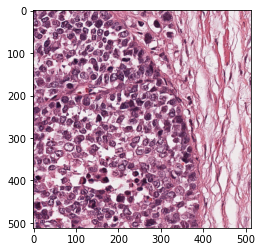

In [2]:
# Test out normalizeStaining
impath = list(root.glob('*/*/*.jpg'))[24]
with PIL.Image.open(impath) as im:
    print(im.mode)
    im = np.asarray(im)
plt.imshow(im);

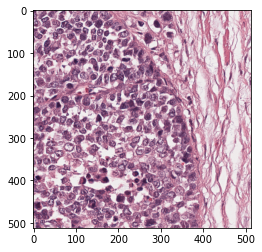

In [3]:
im_norm, h, e = normalizeStaining(im)
plt.imshow(im_norm);

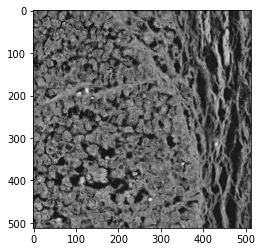

In [4]:
plt.imshow(invert(rgb2gray(e)), cmap='gray');

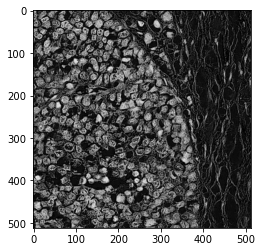

In [5]:
plt.imshow(invert(rgb2gray(h)), cmap='gray');

I was pleased with the performance of the stain normalization tool, so I created a function and a pytorch Transform class to use. The transform class uses a cheap hack to circumvent a problem I had where some crops of some of the tiles didn't have enough information to solve the stain separation (e.g., were blank, horribly out of focus, etc.). I figured feeding random data to the network in a few cases would not have a huge impact on training, but would save me a lot of troubleshooting.

In [6]:
class ExtractStains:
    '''Normalize H&E staining and assign H&E staining to channels'''
    
    def __call__(self, x):
        '''x is a RGB PIL image, returns a Tensor'''
        outarr = np.zeros((2, *x.size))
        im = np.asarray(x)
        try:
            _, h, e = normalizeStaining(im)
            outarr[0, ...] = invert(rgb2gray(h))
            outarr[1, ...] = invert(rgb2gray(e))
        except:
            # This hack saved me a ton of time
            print(f'Failed to normalize image, using random data')
            outarr = np.random.rand(2, *x.size)

        return FloatTensor(outarr)

def extract_stains(pil_im):
    outarr = np.zeros((*pil_im.size, 2))
    im = np.asarray(pil_im)
    _, h, e = normalizeStaining(im)
    outarr[..., 0] = invert(rgb2gray(h))
    outarr[..., 1] = invert(rgb2gray(e))
    return outarr

The next cell was run once to calculate average H&E values for normalization purposes. It also caught some tiles that threw exceptions with the stain normalization tool, which I manually eliminated from the datasets.

## Dataloaders

In the next few cells, I composed my transforms and set up my dataloaders

In [7]:
means = np.array([0.21757233, 0.25600197])
stds = np.array([0.06741126, 0.05294553])

data_transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(192),
        transforms.RandomHorizontalFlip(),
        ExtractStains(),
        transforms.Normalize(mean=means, std=stds)
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(192),
        ExtractStains(),
        transforms.Normalize(mean=means, std=stds)
    ])

In [8]:
#datasets
data_test = ImageFolder(root / "test", transform=data_transform_test)
data_train = ImageFolder(root / "train", transform=data_transform_train)
data_valid = ImageFolder(root / "valid", transform=data_transform_test)

#dataloaders
dl_test = DataLoader(data_test, batch_size=4, shuffle=True)
dl_train = DataLoader(data_train, batch_size=4, shuffle=True)
dl_valid = DataLoader(data_valid, batch_size=4, shuffle=True)

Here, I examine the performance of my dataloaders and see that they are working as intended:

torch.Size([4, 2, 192, 192])


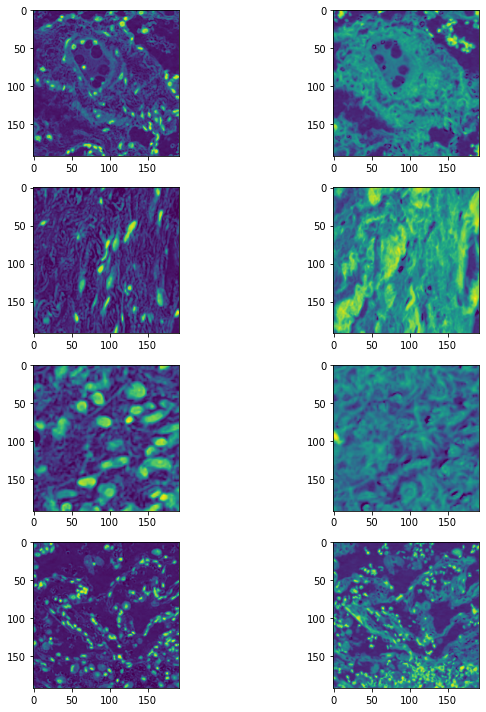

In [9]:
ims, _ = next(iter(dl_train))
print(ims.shape)
fig, axs = plt.subplots(ims.shape[0],2, figsize=(10,10), layout='tight')
for i, ax in enumerate(axs):
    for j, axx in enumerate(ax):
        axx.imshow(ims[i, j, :, :])

## resnet18

Here I am modifying resnet18 to take in a two channel image, and output only 4 possible classes:

In [10]:
# load resnet with random weights and change first and last layers to accomodate these data

model = models.resnet18()
model.conv1 = Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = Linear(in_features=512, out_features=4, bias=True)
model.to(device)

ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In the next couple of cells I set up training as per the previous assignment, using code modified from the tutorials:

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
# From the last project:
def train_model(device, dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

First attempt at training:

In [13]:
dataloaders = {}
dataloaders['train'] = dl_train
dataloaders['test'] = dl_test

dataset_sizes = {}
dataset_sizes['train'] = len(data_train)
dataset_sizes['test'] = len(data_test)

trained_model = train_model(device, dataloaders, dataset_sizes, model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/24
----------


C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice
  eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 1.5381 Acc: 0.2898
test Loss: 1.3707 Acc: 0.3583

Epoch 1/24
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normal

In [14]:
torch.save(trained_model, 'attempt1_resnet18')

Second attempt at training, but using a somewhat more aggressive LR scheduler (larger step size but faster decay). I didn't have a good reason for this, it was just something I wanted to experiment with. I also increased batch size in the dataloaders.

In [17]:
#dataloaders
dl_test = DataLoader(data_test, batch_size=12, shuffle=True)
dl_train = DataLoader(data_train, batch_size=12, shuffle=True)
dl_valid = DataLoader(data_valid, batch_size=12, shuffle=True)
dataloaders = {}
dataloaders['train'] = dl_train
dataloaders['test'] = dl_test

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.05)

# Run model again to see if there is any improvement
trained_model2 = train_model(device, dataloaders, dataset_sizes, model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)
torch.save(trained_model2, 'attempt2_resnet18')

Epoch 0/49
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 1.1417 Acc: 0.4847
test Loss: 1.0813 Acc: 0.5267

Epoch 1/49
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random

C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:80: RuntimeWarning: overflow encountered in exp
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:80: RuntimeWarning: overflow encountered in multiply
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:85: RuntimeWarning: overflow encountered in exp
  H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:85: RuntimeWarning: overflow encountered in multiply
  H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))


Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.9900 Acc: 0.5693
test Loss: 0.9921 Acc: 0.5683

Epoch 24/49
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to norma

I tried one more time with resnet18, this time using best model from last run

In [19]:

optimizer = optim.SGD(trained_model2.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.05)
trained_model3 = train_model(device, dataloaders, dataset_sizes, trained_model2, criterion, optimizer, exp_lr_scheduler, num_epochs=50)
torch.save(trained_model3, 'attempt3_resnet18')

Epoch 0/49
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.9849 Acc: 0.5679
test Loss: 0.9595 Acc: 0.6033

Epoch 1/49
----------
Failed to normalize image, using random data
Failed to normalize image, using random

C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:89: RuntimeWarning: overflow encountered in exp
  E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:89: RuntimeWarning: overflow encountered in multiply
  E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))


Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.8317 Acc: 0.6580
test Loss: 0.8657 Acc: 0.6600

Epoch 38/49
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.8269 Acc: 0.6575
test Loss: 0.9019 Acc: 0.6467

### resnet18 final performance

Best accuracy on test data: 0.667500

## VisionTransformer

I next tried a transformer-based network, choosing mostly default hyperparameters for optimization. Again, this was modified to take a two-channel image and output four different classes.

I saw a few examples of using Adam instead of SGD for ViT, so I tried that first. But that seemed to cause convergence problems, so I switched back to SGD.

In [34]:
model = models.vit_b_16()
model.conv_proj = Conv2d(2, 768, kernel_size=(16, 16), stride=(16, 16))
model.heads.head = Linear(in_features=768, out_features=4, bias=True)
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(2, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [36]:
data_transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        ExtractStains(),
        transforms.Normalize(mean=means, std=stds)
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        ExtractStains(),
        transforms.Normalize(mean=means, std=stds)
    ])

#datasets
data_test = ImageFolder(root / "test", transform=data_transform_test)
data_train = ImageFolder(root / "train", transform=data_transform_train)
data_valid = ImageFolder(root / "valid", transform=data_transform_test)

#dataloaders
dl_test = DataLoader(data_test, batch_size=10, shuffle=True)
dl_train = DataLoader(data_train, batch_size=10, shuffle=True)
dl_valid = DataLoader(data_valid, batch_size=10, shuffle=True)
dataloaders = {}
dataloaders['train'] = dl_train
dataloaders['test'] = dl_test

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

# Run model again to see if there is any improvement
vit_model = train_model(device, dataloaders, dataset_sizes, model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
torch.save(vit_model, 'attempt1_vit')

Epoch 0/9
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 1.4513 Acc: 0.3274
test Loss: 1.5006 Acc: 0.3208

Epoch 1/9
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random d

C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:80: RuntimeWarning: overflow encountered in exp
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:80: RuntimeWarning: overflow encountered in multiply
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:85: RuntimeWarning: overflow encountered in exp
  H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:85: RuntimeWarning: overflow encountered in multiply
  H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))


Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 1.3984 Acc: 0.3739
test Loss: 1.2342 Acc: 0.4225

Epoch 2/9
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normali

10 epochs took about an hour, so I will try 35 more (with less decay in the LR).

In [38]:
optimizer = optim.SGD(vit_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.25)

# Run model again to see if there is any improvement
vit_model2 = train_model(device, dataloaders, dataset_sizes, vit_model, criterion, optimizer, exp_lr_scheduler, num_epochs=35)
torch.save(vit_model2, 'attempt2_vit')

Epoch 0/34
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 1.1832 Acc: 0.4667
test Loss: 1.2928 Acc: 0.4308

Epoch 1/34
-----

And one more training session:

In [39]:
optimizer = optim.SGD(vit_model2.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.25)

# Run model again to see if there is any improvement
vit_model3 = train_model(device, dataloaders, dataset_sizes, vit_model2, criterion, optimizer, exp_lr_scheduler, num_epochs=35)
torch.save(vit_model3, 'attempt3_vit')

Epoch 0/34
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 1.0185 Acc: 0.5534
test Loss: 1.0140 Acc: 0.5575

Epoch 1/34
----------
Failed to normalize image, using random data
Failed to normalize image, using random

C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:77: RuntimeWarning: divide by zero encountered in true_divide
  C2 = np.divide(C,tmp[:, np.newaxis])
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:77: RuntimeWarning: invalid value encountered in true_divide
  C2 = np.divide(C,tmp[:, np.newaxis])


Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.9653 Acc: 0.5857
test Loss: 1.0004 Acc: 0.5625

Epoch 17/34
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to norma

One last training session for the ViT model:

In [40]:
optimizer = optim.SGD(vit_model3.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.25)

# Run model again to see if there is any improvement
vit_model4 = train_model(device, dataloaders, dataset_sizes, vit_model3, criterion, optimizer, exp_lr_scheduler, num_epochs=35)
torch.save(vit_model4, 'attempt4_vit')

Epoch 0/34
----------


C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice
  eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\dmell\miniconda3\envs\ml_course\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.9196 Acc: 0.6103
test Loss: 0.9631 Acc: 0.5833

Epoch 1/34
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normal

C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:80: RuntimeWarning: overflow encountered in exp
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:85: RuntimeWarning: overflow encountered in exp
  H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:85: RuntimeWarning: overflow encountered in multiply
  H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))


Failed to normalize image, using random data
train Loss: 0.8904 Acc: 0.6218
test Loss: 0.9398 Acc: 0.5975

Epoch 7/34
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.8866 Acc: 0.6261
test Loss: 0.9290 Acc: 0.6075

Epoch 8/34
----------
Failed to normalize im

C:\Users\dmell\Projects\roux_ml_final\normalizeStaining.py:80: RuntimeWarning: overflow encountered in multiply
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))


Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
train Loss: 0.7064 Acc: 0.7142
test Loss: 0.9280 Acc: 0.6050

Epoch 27/34
----------
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to normalize image, using random data
Failed to norma

At this point, it looked like the model was starting to overtrain, so:

### ViT_b_16 Final performance

Best accuracy on test data: 0.6275